<a href="https://colab.research.google.com/github/SebastianAblerKratkey/Miscellaneous/blob/main/options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pandas_market_calendars
!pip install nelson_siegel_svensson

In [5]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy.stats as stats
import yfinance as yf
import pandas_market_calendars as mcal
from pandas_datareader.data import DataReader as dr
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

In [15]:
def N(x):
    """ Normal cumulative function

    :param x:
    :return:
    """
    return stats.cdf(x)


def phi(z):
    """ Phi helper function

    :param z:
    :return:
    """
    return np.exp(-0.5 * z * z) / (math.sqrt(2.0 * math.pi))


def call_value(s, k, r, q, t, vol):
    """ Black-Scholes call option

    :param s: underlying
    :param k: strike price
    :param r: rate
    :param q: dividend
    :param t: time to expiration
    :param vol: volatility
    :return: BS call option value
    """
    d1 = (np.log(s/k) + (r - q + 0.5 * vol**2.0) * t) / (vol * np.sqrt(t))
    return s * np.exp(-q * t) * N(d1) - k * np.exp(-r * t) * \
                                        N(d1 - vol * np.sqrt(t))


def put_value(s, k, r, q, t, vol):
    """ Black-Scholes put option

    :param s: underlying
    :param k: strike price
    :param r: rate
    :param q: dividend
    :param t: time to expiration
    :param vol: volatility
    :return: BS put option value
    """

    d1 = (np.log(s/k) + (r - q + 0.5 * vol**2.0) * t) / (vol * np.sqrt(t))
    return k * np.exp(-r * t) * N(-(d1 - vol * np.sqrt(t)) ) - s * \
                                        np.exp(-q * t) * N(-d1)

def call_payoff(s, k, r, q, t, vol, option_premium, option_trade_qty,
                underlying_shares=100.0):
    """ Returns BS payoff in dollars

    """
    return (call_value(s, k, r, q, t, vol) - option_premium) * \
            option_trade_qty * underlying_shares


def put_payoff(s, k, r, q, t, vol, option_premium, option_trade_qty,
               underlying_shares=100.0):
    """ Returns BS payoff in dollars

    """
    return (put_value(s, k, r, q, t, vol) - option_premium) * \
            option_trade_qty * underlying_shares


def underlying_payoff(s, underlying_price, underlying_trade_qty):
    """ Returns payoff of underlying

    """
    return (s - underlying_price) * float(underlying_trade_qty)



def call_delta(s, k, r, q, t, vol):
    """ Black-Scholes call delta

    :param s: underlying
    :param k: strike price
    :param r: rate
    :param q: dividend
    :param t: time to expiration
    :param vol: volatility
    :return: BS call delta
    """
    d1 = (np.log(s/k) + (r - q + 0.5 * vol**2.0) * t) / (vol * np.sqrt(t))
    return np.exp(-q*t)*N(d1)


def put_delta(s, k, r, q, t, vol):
    """ Black-Scholes put delta

    :param s: underlying
    :param k: strike price
    :param r: rate
    :param q: dividend
    :param t: time to expiration
    :param vol: volatility
    :return: BS put delta
    """
    d1 = (np.log(s/k) + (r - q + 0.5 * vol**2.0) * t) / (vol * np.sqrt(t))
    return -np.exp(-q*t)*N(-d1)


def underlying_delta():
    """ Black-Scholes underlying delta

    :return: underlying delta
    """
    return 1.0


def call_gamma(s, k, r, q, t, vol):
    """ Black-Scholes gamma

    :param s: underlying
    :param k: strike price
    :param r: rate
    :param q: dividend
    :param t: time to expiration
    :param vol: volatility
    :return: BS gamma
    """
    d1 = (np.log(s/k) + (r - q + 0.5 * vol**2.0) * t) / (vol * np.sqrt(t))
    return np.exp(-q*t) * phi(d1) / (s * vol * np.sqrt(t))


def put_gamma(s, k, r, q, t, vol):
    """ Black-Scholes gamma

    :param s: underlying
    :param k: strike price
    :param r: rate
    :param q: dividend
    :param t: time to expiration
    :param vol: volatility
    :return: BS gamma
    """
    d1 = (np.log(s/k) + (r - q + 0.5 * vol**2.0) * t) / (vol * np.sqrt(t))
    return np.exp(-q*t) * phi(d1) / (s * vol * np.sqrt(t))


def call_vega(s, k, r, q, t, vol, underlying_shares=100.):
    """ Black-Scholes vega

    :param s: underlying
    :param k: strike price
    :param r: rate
    :param q: dividend
    :param t: time to expiration
    :param vol: volatility
	:underlying_shares: shares of underlying
    :return: BS vega
    """
    d1 = (np.log(s/k) + (r - q + 0.5 * vol**2.0) * t) / (vol * np.sqrt(t))
    return (s * np.exp(-q*t) * phi(d1) * np.sqrt(t)) / underlying_shares


def put_vega(s, k, r, q, t, vol, underlying_shares=100.):
    """ Black-Scholes vega

    :param s: underlying
    :param k: strike price
    :param r: rate
    :param q: dividend
    :param t: time to expiration
    :param vol: volatility
	:underlying_shares: shares of underlying
    :return: BS vega
    """
    d1 = (np.log(s/k) + (r - q + 0.5 * vol**2.0) * t) / (vol * np.sqrt(t))
    return (s * np.exp(-q*t) * phi(d1) * np.sqrt(t)) / underlying_shares


def call_theta(s, k, r, q, t, vol):
    """ Black-Scholes call theta

    :param s: underlying
    :param k: strike price
    :param r: rate
    :param q: dividend
    :param t: time to expiration
    :param vol: volatility
	:days: theta per day
    :return: BS call theta
    """
    d1 = (np.log(s/k) + (r - q + 0.5 * vol**2.0) * t) / (vol * np.sqrt(t))
    d2 = d1 - vol * np.sqrt(t)
    res = -np.exp(-q*t) * s * phi(d1) * vol * 0.5 / np.sqrt(t) - r *\
                k * np.exp(-r*t) * N(d2) + q * s * np.exp(-q*t) * N(d1)
    return res / 365.0


def put_theta(s, k, r, q, t, vol):
    """ Black-Scholes put theta

    :param s: underlying
    :param k: strike price
    :param r: rate
    :param q: dividend
    :param t: time to expiration
    :param vol: volatility
	:days: theta per day
    :return: BS put theta
    """
    d1 = (np.log(s/k) + (r - q + 0.5 * vol**2.0) * t) / ( vol * np.sqrt(t))
    d2 = d1 - vol * np.sqrt(t)
    res = -np.exp(-q*t) * s * phi(d1) * vol * 0.5 / np.sqrt(t) + r * \
             k * np.exp(-r*t) * N(-d2) - q * s * np.exp(-q*t) * N(-d1)
    return res / 365.0


def call_rho(s, k, r, q, t, vol, underlying_shares=100.0):
    """ Black-Scholes call rho

    :param s: underlying
    :param k: strike price
    :param r: rate
    :param q: dividend
    :param t: time to expiration
    :param vol: volatility
	:underlying_shares: shares of underlying
    :return: BS call rho
    """
    d2 = (np.log(s/k) + (r - q - 0.5 * vol**2.0) * t) / (vol * np.sqrt(t))
    return (k * t * np.exp(-r*t) * N(d2)) / underlying_shares


def put_rho(s, k, r, q, t, vol, underlying_shares=100.0):
    """ Black-Scholes call rho

    :param s: underlying
    :param k: strike price
    :param r: rate
    :param q: dividend
    :param t: time to expiration
    :param vol: volatility
	:underlying_shares: shares of underlying
    :return: BS call rho
    """
    d2 = (np.log(s/k) + (r - q - 0.5 * vol**2.0) * t) / (vol * np.sqrt(t))
    return (-k * t * np.exp(-r*t) * N(-d2)) / underlying_shares

In [ ]:
# yahoo finance ticker symbol
ticker = "SPY"

# spot price of underlying
s = yf.download(ticker, period='1d', interval='1d')["Close"].iloc[-1]

# time to expiration

In [6]:
# yahoo finance ticker symbol
ticker = "SPY"

# option variables

#spot_price = 300
spot_price = yf.download("SPY", period='1d', interval='1d')["Close"].iloc[-1]

strike_price = 250


# time data

#current_date = '2024-01-28'
current_date = datetime.now()
expiration_date = '2024-06-10'
# get trading days
exchange = 'NYSE'  # select exchange
cal = mcal.get_calendar(exchange)
trading_days = mcal.date_range(cal.schedule(start_date=current_date, end_date=expiration_date), frequency='1D')
number_trading_days = len(trading_days) - 1                 #excluding current day from trading days

trading_days_per_year = 252                                 #fair to assume 252
time_in_years = number_trading_days/trading_days_per_year
delta_t = time_in_years / number_trading_days               #leangth of time step

# implied volatility
impl_vol = 0.15


number_trading_days

[*********************100%%**********************]  1 of 1 completed


58

In [7]:
# calculate riskfree-rate via the Nelson-Siegel-Svensson method based on U.S. Treasury yields

# get yield curve data
syms = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
yc = dr(syms, 'fred', start=current_date - timedelta(days=10))
yield_maturities = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yeilds = np.array(yc.iloc[-1,:]).astype(float)/100

#NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturities,yeilds)

# risk-free rate
rf = curve_fit(time_in_years)
rf

0.05483635745328391

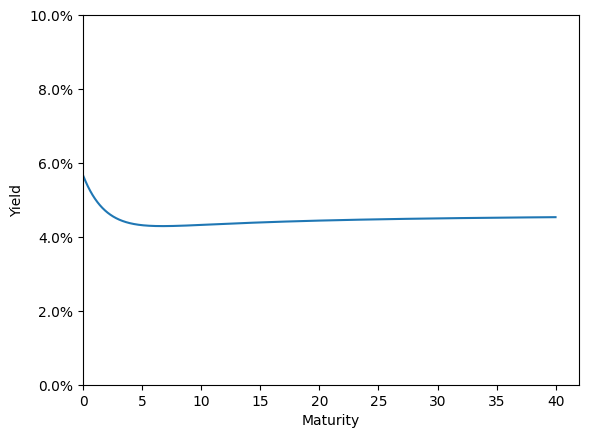

In [8]:
plot_maturities = np.arange(0, 40, 0.01)
plot_yields = curve_fit(plot_maturities)
plt.plot(plot_maturities, plot_yields)
plt.xlabel('Maturity')
plt.ylabel('Yield')
plt.ylim(0, 0.10)
plt.xlim(0)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:,.1%}'.format))
plt.show()
plt.show()

In [9]:
# run monte carlo simmulation

sim_runs = 300000

random_growth_factors = np.exp((rf-0.5*impl_vol**2)*delta_t + impl_vol*(delta_t**0.5)*np.random.normal(0, 1, size=(number_trading_days, sim_runs)))

growth_t0 = np.ones((1, random_growth_factors.shape[1])) * spot_price
growth_paths = np.vstack((growth_t0, random_growth_factors))
cumulative_growth_paths = np.cumprod(growth_paths, axis=0)

#simulated_performance = pd.DataFrame(cumulative_growth_paths)
#simulated_performance

In [10]:
prices_maturity = cumulative_growth_paths[-1]

payoff_long_call = np.maximum((prices_maturity-strike_price),0)
price_long_call = payoff_long_call.mean() * np.exp(-rf*time_in_years)
price_long_call

262.9511852129587

In [11]:
# simulation dataframe with dates

simulation_df = pd.DataFrame(cumulative_growth_paths)
simulation_df.set_index(pd.Index(trading_days), inplace=True)
simulation_df

,0,1,2,3,4,5,6,7,8,9,...,299990,299991,299992,299993,299994,299995,299996,299997,299998,299999
2024-03-18 20:00:00+00:00,509.829987,509.829987,509.829987,509.829987,509.829987,509.829987,509.829987,509.829987,509.829987,509.829987,...,509.829987,509.829987,509.829987,509.829987,509.829987,509.829987,509.829987,509.829987,509.829987,509.829987
2024-03-19 20:00:00+00:00,509.981281,516.429446,515.709220,509.054290,500.986991,520.009905,512.821179,507.285538,509.574624,504.692777,...,514.654832,510.934486,514.220236,504.187761,509.311945,503.913493,510.929778,513.265251,505.650979,513.787376
2024-03-20 20:00:00+00:00,508.119774,519.135462,516.714242,507.127171,505.624767,521.462404,501.677508,510.600686,507.176861,511.063487,...,512.141322,511.333109,508.546811,505.673352,528.268187,508.738278,518.792441,508.996934,503.895741,506.864377
2024-03-21 20:00:00+00:00,503.739678,522.724783,514.228700,502.471351,509.740778,526.477141,497.374675,506.586689,507.886850,514.979923,...,510.645822,514.726854,513.275836,508.920610,521.783420,514.164384,522.116077,496.213012,510.092305,506.119214
2024-03-22 20:00:00+00:00,505.792723,526.435558,513.870658,497.467306,513.403608,524.814776,494.983862,510.631771,518.913864,515.693078,...,514.178458,513.905490,514.524705,509.615825,533.571446,513.363356,525.609034,490.328291,505.620221,495.036227
2024-03-25 20:00:00+00:00,505.854906,523.959077,518.226777,500.772283,516.657835,531.493552,491.293670,506.457393,514.252264,509.152551,...,504.265088,516.095026,516.465159,513.405309,524.770034,502.434238,527.139700,491.481568,493.715885,489.606827
2024-03-26 20:00:00+00:00,502.446613,530.936736,519.421846,489.370748,508.208535,526.572484,488.483896,509.812425,511.047708,514.172661,...,503.333019,524.290129,522.525045,509.857951,526.358583,504.295244,521.477195,489.655439,493.627091,497.196732
2024-03-27 20:00:00+00:00,506.698181,523.809549,519.988509,492.825203,508.337790,521.287334,486.377911,509.786886,516.217407,518.448143,...,498.865609,516.884774,528.304498,508.318102,537.219608,509.170725,524.353651,489.425245,495.653382,505.730516
2024-03-28 20:00:00+00:00,509.362667,514.715610,518.759571,493.735724,504.551208,525.576619,491.387408,512.272051,516.415991,514.933580,...,496.214507,513.618952,526.165083,511.856181,540.814737,515.529304,523.696538,486.642206,487.291371,510.502570
2024-04-01 20:00:00+00:00,504.707425,512.847449,521.162571,493.324762,510.609366,523.188375,488.154538,518.193188,513.858525,514.747080,...,494.906214,515.461192,527.025498,508.552102,539.040399,522.133568,529.655176,481.669840,488.076976,509.917034


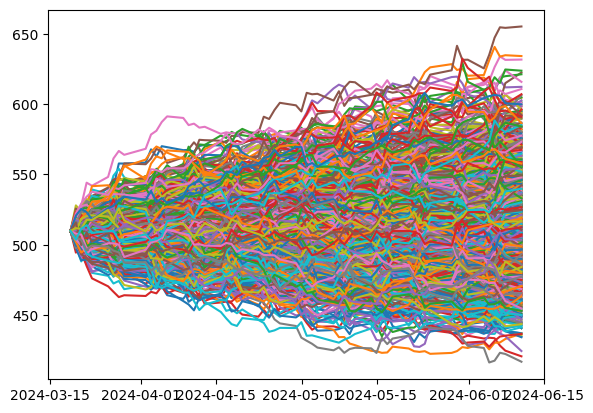

In [12]:
plt.plot(simulation_df.iloc[:, :1000])
plt.show()